In [1280]:
import numpy as np
import sympy, scipy, cmath
from sympy import *
#from sympy import symbols
#from sympy.solvers.solveset import nonlinsolve
from scipy import sparse as sp
#from scipy import linalg as ln
from scipy import optimize as opt
from scipy.sparse import  coo_matrix as cmm
from matplotlib import pyplot as pp
import pylab

In [1460]:
#Parameters
#default values: mu=1.8 m=.5 t=3 alR=.7 B=3.07 delta=.5 phi=Pi

kx=0.

mu=3.
muSC=50.
m=.5
#mSC=0.05
t=1.1
alR=0.
#B=3.07
#delta=.5
phi=np.pi

def mut(kx):
    return mu-2*t-kx**2/(2*m)#-alR**2*m/2
def kF(mu):
    return cmath.sqrt(2*m*mu)
def a(t):
    return 1/cmath.sqrt(2*m*t)

def delL(delta):
    return delta*cmath.exp(1j*phi/2)
def delR(delta):
    return delta*cmath.exp(-1j*phi/2)
def nu0(m):
    return m/(2*np.pi)
def xiE(En):
    return kF(muSC)/(m*cmath.sqrt(delta**2-En**2))

tL=.1
tR=0.1

NJ=1

gamma=np.pi*nu0(m)*tL**2
#matrix tools
eye2=np.eye(2)
eye4=np.eye(4)
s1=[[0,1],[1,0]]
s2=[[0,-1j],[1j,0]]
s3=[[1,0],[0,-1]]
tP=np.kron([[0,1],[0,0]],eye2)
tM=np.kron([[0,0],[1,0]],eye2)
t3=np.kron(s3,eye2)

In [1462]:
#Junction
def HJ0(kx,B):
    return -mut(kx)*t3+alR*kx*np.kron(s3,s2)+B*np.kron(eye2,s1)
def Hy(alR):
    return -t*t3+1j*alR/2/a(t)*np.kron(s3,s1)


def HJ(kx,B):
    start=cmm(HJ0(kx,B))
    HJs=start
    for n in range(0,NJ-1):
        OT=cmm(np.zeros([len(HJs.toarray())-4,4]))
        BT=sp.vstack([OT,cmm(Hy(alR))])
        CT=sp.hstack([OT.transpose(),cmm(Hy(alR).conj().T),start])
        HJs=sp.hstack([HJs,BT])
        HJs=sp.vstack([HJs,CT])
    return HJs

def gJm1(En,kx,B):
    return En*np.eye(4*NJ)-HJ(kx,B).toarray()

#Superconductors
# xiE-> infty to avoid more symbolic:
#def fL(kx):
#    return 1/(kF*a)*(np.log(1-np.exp(1j*a*(kF+kx)))+np.log(1-np.exp(1j*a*(kF-kx))))-1j

def fL(En,kx):
    return 1/(kF(muSC)*a(t))*(cmath.log(1-cmath.exp(-a(t)/xiE(En)+1j*a(t)*(kF(muSC)+kx)))+\
                         cmath.log(1-cmath.exp(-a(t)/xiE(En)+1j*a(t)*(kF(muSC)-kx))))-1j

def gSC1m1(En,kx,delta):
    return -1/(np.pi*nu0(m)*abs(fL(En,kx))**2)*((En*eye4 - delL(delta)*tP - np.conj(delL(delta))*tM)*\
                                                 fL(En,kx).imag/cmath.sqrt(delta**2 - En**2) - fL(En,kx).real*t3)

def gSC2m1(En,kx,delta):
    return -1/(np.pi*nu0(m)*abs(fL(En,kx))**2)*((En*eye4 - delR(delta)*tP - np.conj(delR(delta))*tM)*\
                                                 fL(En,kx).imag/cmath.sqrt(delta**2 - En**2) - fL(En,kx).real*t3)

#SC/J coupling
rowindex=np.array([1,2,3,4,4*NJ+1,4*NJ+2,4*NJ+3,4*NJ+4])-1
colindex=np.array([5,6,7,8,4*(NJ+1)+1,4*(NJ+1)+2,4*(NJ+1)+3,4*(NJ+1)+4])-1

def hoppings(tL,tR):
    return [tL,tL,-tL,-tL,tR,tR,-tR,-tR]
def mHt1(tL,tR):
    return cmm((hoppings(tL,tR),(rowindex,colindex)),shape=(4*(NJ+2),4*(NJ+2)))
def mHt(tL,tR):
    return mHt1(tL,tR)+mHt1(tL,tR).transpose()

#total inverse GF
def Gtotm1(En,kx,delta,B,tL,tR):
    return scipy.linalg.block_diag(gSC1m1(En,kx,delta),gJm1(En,kx,B),gSC2m1(En,kx,delta))+mHt(tL,tR).toarray()

to optimize by avoiding the computation of gSC1m1 when calling fdetB

In [1463]:
M=30
Delarray=np.linspace(0.0001,10,M+1)

In [1464]:
PDtr=np.zeros((M+1,NJ))#2*NJ))

En=0

for qq in range(M+1):
    delta=Delarray[qq]
    print(qq)
    ekxB=[]
    def fdetB(B):
        return np.linalg.det(Gtotm1(En,kx,delta,B,tL,tR))/(mu**(4.*(NJ+2)))
    x0roots=np.ndarray.tolist(np.linspace(0,100,5))
    for i in range(len(x0roots)):
        x0=x0roots[i]
        solekx=opt.fsolve(fdetB,np.asarray(x0))
        if abs(fdetB(solekx))>10**-6 or solekx<0:
            solekx=[]
        solekx=np.ndarray.tolist(np.around(solekx,6))
        ekxB.extend(solekx)
    ekxB=np.sort(list(set(ekxB)))
    print(ekxB)
    if len(ekxB)<NJ: ###here 2*
        zerocompletion=[0]*(NJ-len(ekxB)) ###here
        ekxB.extend(zerocompletion)
    elif len(ekxB)>NJ:  ###here
        print("Too many roots.")
        break
    PDtr[qq]=np.asarray(ekxB)

0
[0.801169]
1
[0.801184]
2
[0.801195]
3
[0.801203]
4
[0.801207]
5
[0.801208]
6
[0.801206]
7
[0.801201]
8
[0.801194]
9
[0.801184]
10
[0.801173]
11
[0.801159]
12
[0.801144]
13
[0.801128]
14
[0.80111]
15
[0.801091]
16
[0.801072]
17
[0.801052]
18
[0.801032]
19
[0.801011]
20
[0.80099]
21
[0.800969]
22
[0.800949]
23
[0.800928]
24
[0.800907]
25
[0.800886]
26
[0.800866]
27
[0.800846]
28
[0.800826]
29
[0.800806]
30
[0.800787]


In [1473]:
dlist=Delarray

def RefL(dt):
    delta=dt
    return fL(0,0).real
def ImfL(dt):
    delta=dt
    return fL(0,0).imag
def absfL(dt):
    delta=dt
    return np.abs(fL(0,0))
gamma=np.pi*nu0(m)*tL**2
Barray=[np.sqrt(mut(0)**2+gamma*(-2*RefL(delta)*mut(0)+gamma*absfL(delta)**2)) for delta in dlist]
Barray2=[np.sqrt(mut(0)**2+2*gamma*(-2*RefL(delta)*mut(0)+gamma*absfL(delta)**2)+2*gamma**2*ImfL(delta)**2*np.cos(phi))\
         for delta in dlist]

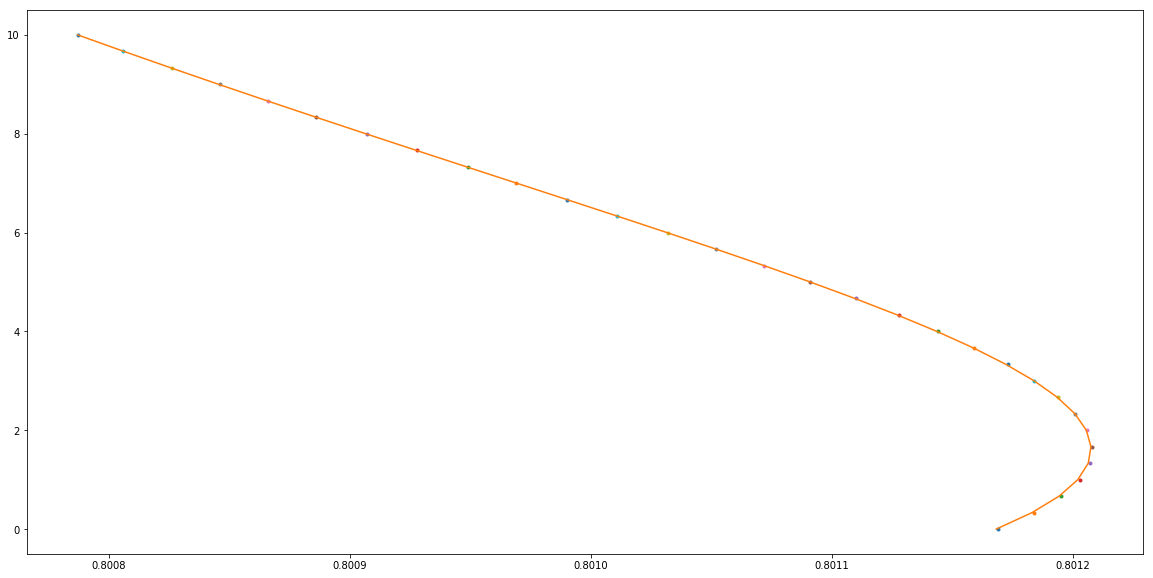

In [1474]:
pp.figure(figsize=(20,10))
for p in range(len(PDtr)):
    pp.plot(PDtr[p],[Delarray[p]]*(NJ),'.')

pp.plot(Barray2,dlist)

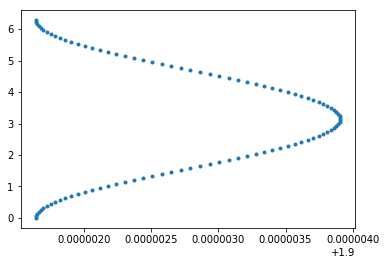

In [1479]:
phiphi=np.linspace(0,2*np.pi,100)
Barray=[np.sqrt(mut(0)**2+t**2+gamma**2+t*np.sqrt(4*mut(0)**2+2*gamma**2*(1-np.cos(ph)))) for ph in phiphi]
Barray2=[np.sqrt(mut(0)**2+t**2+gamma**2-t*np.sqrt(4*mut(0)**2+2*gamma**2*(1-np.cos(ph)))) for ph in phiphi]
pp.plot(Barray,phiphi,'.')
#pp.plot(Barray2,phiphi,'.')

In [1320]:
2*np.sqrt(t*muSC)

3.6331804249169903

In [1171]:
Barray[0]

133.55564818629264

In [1336]:
dgrid=np.linspace(0,10,201)+0.0001
mugrid=np.linspace(0,20,401)+0.1

def fLoo(delta,muSC):
    xE=kF(muSC)/m/delta
    return 2/(kF(muSC)*a(t))*(cmath.log(1-cmath.exp(-a(t)/xE+1j*a(t)*kF(muSC))))-1j

ReLoo=[[np.around(fLoo(dt,du).real,2) for du in mugrid] for dt in dgrid]
ImLoo=[[np.around(fLoo(dt,du).imag,2) for du in mugrid] for dt in dgrid]
AbsLoo=[[-ReLoo[i][j]**2-ImLoo[i][j]**2 for j in range(len(mugrid))] for i in range(len(dgrid))]

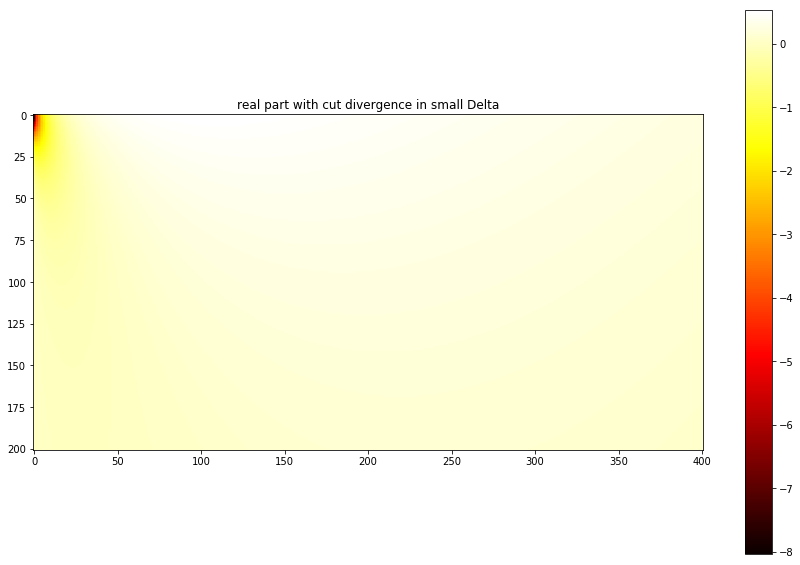

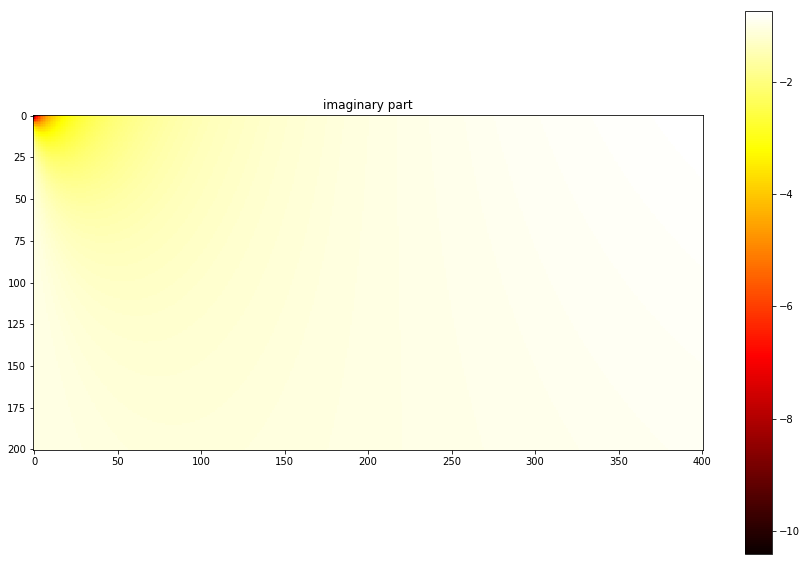

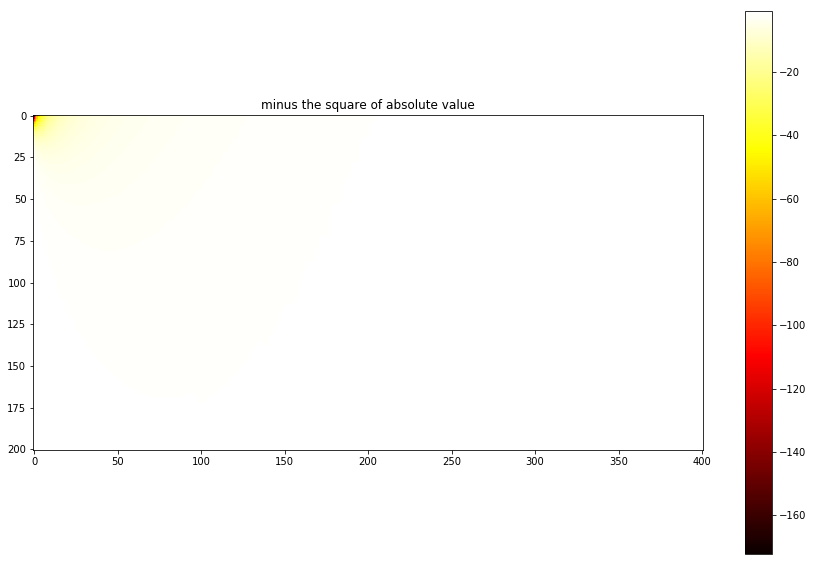

In [1337]:
pp.figure(figsize=(15,10))
pp.imshow(ReLoo,cmap='hot')
pp.title('real part with cut divergence in small Delta')
pp.colorbar()

pp.figure(figsize=(15,10))
pp.imshow(ImLoo,cmap='hot')
pp.title('imaginary part')
pp.colorbar()

pp.figure(figsize=(15,10))
pp.imshow(AbsLoo,cmap='hot')
pp.title('minus the square of absolute value')
pp.colorbar()

In [1331]:
np.asarray(ReLoo)[:,10]

array([0.06, 0.06, 0.05, 0.05, 0.04, 0.04, 0.03, 0.03, 0.03, 0.02, 0.02,
       0.02, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.

In [955]:
gamma

0.0025000000000000005

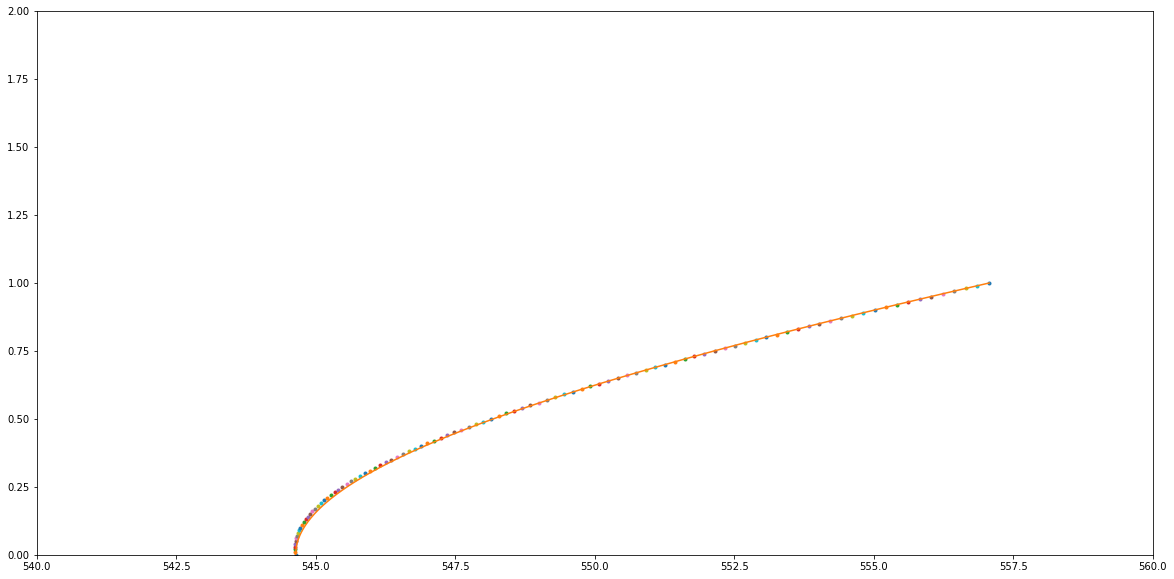

In [239]:
pp.figure(figsize=(20,10))
for p in range(len(PDtr)):
    pp.plot(PDtr[p],[Delarray[p]]*(NJ),'.')
pp.axis([540,560,0,2])
Blist=np.linspace(544.6417,557.0705,1000)
b=900.
n=1/np.sqrt((557.0705-544.6417+np.sqrt(b))**2-b)
pp.plot(Blist,[n*np.sqrt((xc+np.sqrt(b)-544.6417)**2-b) for xc in Blist])

In [214]:
np.sqrt(557.0705**2-544.6418**2)

117.0164589406551

In [944]:
tLarray=[0.0001+i/10. for i in range(401)]
#tLarray.extend([i for i in range(4,200)])
delta=.1
En=0

tLdep=np.zeros(len(tLarray))
for fd in range(len(tLarray)):
    print(fd)
    mu=tLarray[fd]
    
    ekxB=[]
    def fdetB(B):
        return np.linalg.det(Gtotm1(En,kx,delta,B,tL))/(mu**(4.*(NJ+0)))
    x0roots=np.ndarray.tolist(np.linspace(0,100,12))
    for i in range(len(x0roots)):
        x0=x0roots[i]
        solekx=opt.fsolve(fdetB,np.asarray(x0))
        if abs(fdetB(solekx))>10**-6 or solekx<0:
            solekx=[]
        solekx=np.ndarray.tolist(np.around(solekx,4))
        ekxB.extend(solekx)
    ekxB=list(set(ekxB))
    print(ekxB)
    if len(ekxB)<NJ: ###here 2*
        zerocompletion=[0]*(NJ-len(ekxB)) ###here
        ekxB.extend(zerocompletion)
    elif len(ekxB)>NJ:  ###here
        print("Too many roots.")
        break
    tLdep[fd]=np.asarray(ekxB)

0
[167.3847]
1
[996.9186]
2
[701.9002]
3
[565.4783]
4
[485.2878]
5
[431.7459]
6
[393.0673]
7
[363.5877]
8
[340.2285]
9
[321.1647]
10
[305.2417]
11
[291.6913]
12
[279.9814]
13
[269.7309]
14
[260.6593]
15
[252.5552]
16
[245.2563]
17
[238.6353]
18
[232.5914]
19
[227.0432]
20
[221.9245]
21
[217.1806]
22
[212.7662]
23
[208.6432]
24
[204.7794]
25
[201.1472]
26
[197.7231]
27
[194.4867]
28
[191.4205]
29
[188.5089]
30
[185.7384]
31
[183.0971]
32
[180.5745]
33
[178.1612]
34
[175.8487]
35
[173.6297]
36
[171.4974]
37
[169.4456]
38
[167.4691]
39
[165.5627]
40
[163.7219]
41
[161.9428]
42
[160.2214]
43
[158.5544]
44
[156.9387]
45
[155.3712]
46
[153.8495]
47
[152.3709]
48
[150.9333]
49
[149.5344]
50
[148.1725]
51
[146.8455]
52
[145.552]
53
[144.2902]
54
[143.0588]
55
[141.8562]
56
[140.6814]
57
[139.533]
58
[138.41]
59
[137.3112]
60
[136.2357]
61
[135.1825]
62
[134.1508]
63
[133.1398]
64
[132.1485]
65
[131.1764]
66
[130.2227]
67
[129.2867]
68
[128.3678]
69
[127.4655]
70
[126.579]
71
[125.708]
72
[124.

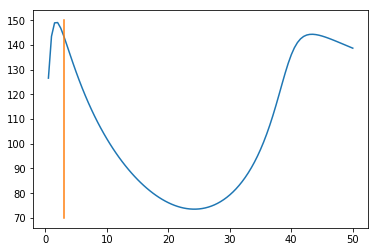

In [937]:
pp.plot(tLarray[1:],tLdep[1:])
pp.plot([delta]*10,np.linspace(70,150,10))
#pp.plot(tLarray[1:],[40000./x**2.7+100 for x in tLarray[1:]],'.')
#pylab.ylim([99,130])

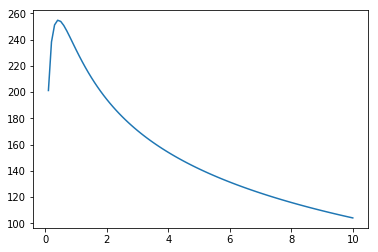

In [943]:
pp.plot(tLarray[1:],tLdep[1:])
#pp.plot(tLarray[1:],[40000./x**2.7+100 for x in tLarray[1:]],'.')
#pylab.ylim([0,700])

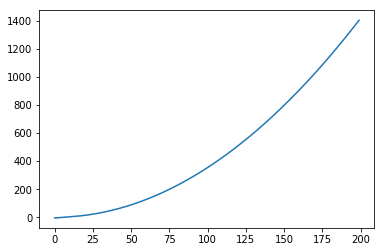

In [591]:
pp.plot(tLarray,[-tLdep[op]+tLarray[op]**2/4.6+tLarray[op]/6.2+8.6+(tLarray[op]-95)**2/1170.-17.2 \
                      for op in range(len(tLarray))])

In [368]:
1/6.2-190/1170.

-0.0011028398125172423

(0, 10)

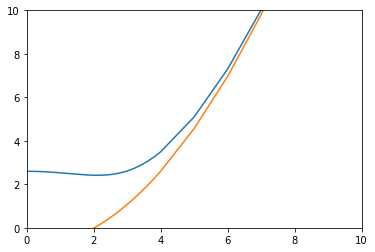

In [343]:
pp.plot(tLarray,tLdep)
pp.plot(tLarray,[0.21823893*op**2-0.8863 for op in tLarray])
pylab.xlim([0,10])
pylab.ylim([0,10])

In [714]:
yl=[0.18278836*op**2-0.9981 for op in tLarray]
pk=[np.sqrt(lj**2+(mut(0)-0.1411)**2) for lj in yl]

In [722]:
3.4589/mut(0)

0.9608055555555555

(0, 10)

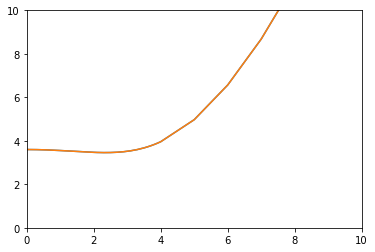

In [715]:
pp.plot(tLarray,tLdep)
pp.plot(tLarray,pk)
pylab.xlim([0,10])
pylab.ylim([0,10])

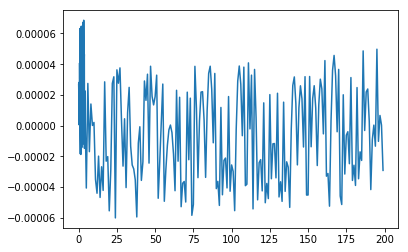

In [716]:
diff=[pk[g]-tLdep[g] for g in range(len(tLarray))]
pp.plot(tLarray,diff)
#pylab.ylim([0.074,0.0755])

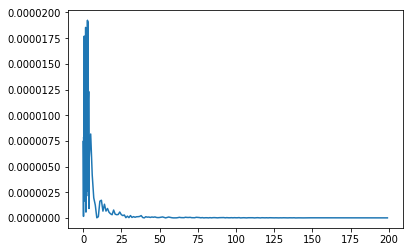

In [723]:
diff=[abs(pk[g]-tLdep[g])/abs(pk[g]) for g in range(len(tLarray))]
pp.plot(tLarray,diff)
#pylab.ylim([0.074,0.0755])

In [414]:
diff

[0.026404936410225233,
 0.026406605194966293,
 0.026421047653138352,
 0.02647665786778175,
 0.026521044262328264,
 0.026621453538631545,
 0.02666535664275793,
 0.02676118786719961,
 0.026839223697166403,
 0.026952581978511247,
 0.02707831404823935,
 0.02721855226938441,
 0.027301662665984328,
 0.027483336930002267,
 0.027547540110868685,
 0.027707210370385926,
 0.027804586484397653,
 0.027911019318733743,
 0.02802610831990382,
 0.028075997216624682,
 0.028010669594143778,
 0.02800011012443493,
 0.028029245766555633,
 0.027891655926053804,
 0.027782140364304375,
 0.027488352203672406,
 0.027281828107251993,
 0.02690886049910368,
 0.02658173649744766,
 0.026070895607182898,
 0.025598520652435397,
 0.025033972879881627,
 0.024391324881746446,
 0.023829057584776603,
 0.023151799594335998,
 0.022413827052168322,
 0.021723930597592922,
 0.02095120235447956,
 0.020231297817698835,
 0.01947277391823743,
 0.018763179621319015,
 0.018763179621319015,
 0.012521346144287904,
 0.008444522154142042,

In [440]:
2.6/1.076087

2.4161615185389285

In [441]:
2.6-0.184

2.416

In [448]:
0.25/0.227072*0.9611

1.0581445532694476